# FVI Clustering

This notebook filters frames based on FVI scores, creates embeddings for the selected frames, and clusters the embeddings.

In [1]:
import os
import json
import numpy as np
import torch
import torch.nn as nn
from torchvision import models, transforms
from PIL import Image
import random


# Add the path to the scripts directory
import sys
sys.path.append('../scripts')
print(np.__version__)

1.26.4


## Load FVI Scores

Load the FVI scores from the `fvi_scores.json` file.

In [2]:
def load_fvi_scores(directory):
    fvi_scores = {}
    for root, _, files in os.walk(directory):
        for file in files:
            if file == 'fvi_scores.json':
                filepath = os.path.join(root, file)
                with open(filepath, 'r') as f:
                    scores = json.load(f)
                    fvi_scores[root] = scores
    return fvi_scores

fvi_scores = load_fvi_scores('../output/fvi_computation')

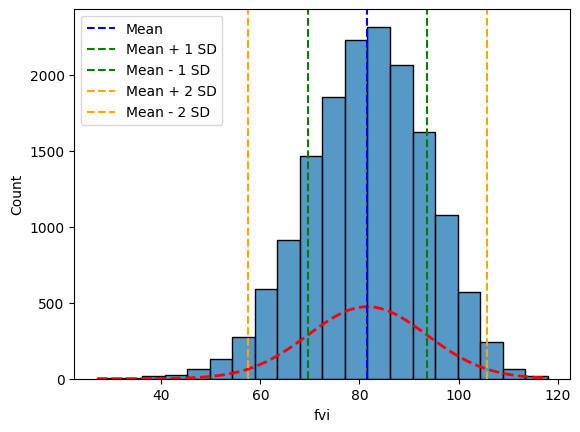

In [3]:
# create a chart to show the distribution of the fvi scores
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from scipy.stats import norm

# Example fvi_scores dictionary for demonstration purposes
fvi_scores_list = []
for root, scores in fvi_scores.items():
    for score in scores:
        fvi_scores_list.append(score)

df = pd.DataFrame(fvi_scores_list, columns=['fvi'])

sns.histplot(df, x='fvi', bins=20)

# add a bell curve
mu, std = norm.fit(df['fvi'])
min_fvi, max_fvi = df['fvi'].min(), df['fvi'].max()
x = np.linspace(min_fvi, max_fvi, 100)
y = norm.pdf(x, mu, std) * len(df) * (x[1] - x[0])
plt.plot(x, y, 'r--', linewidth=2)

# Add standard deviation lines
plt.axvline(mu, color='blue', linestyle='--', label='Mean')
plt.axvline(mu + std, color='green', linestyle='--', label='Mean + 1 SD')
plt.axvline(mu - std, color='green', linestyle='--', label='Mean - 1 SD')
plt.axvline(mu + std * 2, color='orange', linestyle='--', label='Mean + 2 SD')
plt.axvline(mu - std * 2, color='orange', linestyle='--', label='Mean - 2 SD')
plt.legend()

plt.show()

## Filter Frames

Filter frames with FVI scores above a certain threshold.
low FVI scores => redundant

In [ ]:
#threshold = 120 # optimal threshold value not neglecting important frames
threshold = mu - std * 2
#print threshold
print(f"Threshold Value: {threshold}")
threshold = 100 #TEMP THRESHOLD FOR TESTING



selected_frames_images = []
frame_ground_truth = []
for directory, scores in fvi_scores.items():
    for i, score in enumerate(scores):
        if score > threshold:
            directory = directory.replace("\\", "/")

            # Adjusting the directory path to replace "../output/ground_truth" with "/data"
            adjusted_directory = directory.replace("../output/fvi_computation", "../data/ground_truth")
            adjusted_directory_image = directory.replace("../output/fvi_computation", "../output/video_frames")

            # Adjusting the directory path to replace "/preds" with ""
            adjusted_directory_image = adjusted_directory_image.replace("preds", "")

            ground_truth_path = os.path.join(adjusted_directory, f'{i+1:04d}.json')
            image_path = os.path.join(adjusted_directory_image, f'{i+1:04d}.jpg')
            image_path = image_path.replace("\\", "/")
            ground_truth_path = ground_truth_path.replace("\\", "/")
            selected_frames_images.append(image_path)
            frame_ground_truth.append(ground_truth_path)

print(len(frame_ground_truth))
print(frame_ground_truth[:5])
print(selected_frames_images[:5])

Threshold Value: 57.549852885531465
15143
['../data/ground_truth/417/VID003A/preds/0004.json', '../data/ground_truth/417/VID003A/preds/0005.json', '../data/ground_truth/417/VID003A/preds/0006.json', '../data/ground_truth/417/VID003A/preds/0007.json', '../data/ground_truth/417/VID003A/preds/0008.json']
['../output/video_frames/417/VID003A/0004.jpg', '../output/video_frames/417/VID003A/0005.jpg', '../output/video_frames/417/VID003A/0006.jpg', '../output/video_frames/417/VID003A/0007.jpg', '../output/video_frames/417/VID003A/0008.jpg']


In [5]:
sys.path.append('../scripts')

from coco_converter import convert_selected_frames_to_coco

print(frame_ground_truth[:5]) # selected frame is actually the json groundtruth file.
convert_selected_frames_to_coco(frame_ground_truth, '../output/selected_frames_coco.json')

['../data/ground_truth/417/VID003A/preds/0004.json', '../data/ground_truth/417/VID003A/preds/0005.json', '../data/ground_truth/417/VID003A/preds/0006.json', '../data/ground_truth/417/VID003A/preds/0007.json', '../data/ground_truth/417/VID003A/preds/0008.json']


KeyboardInterrupt: 

## Create Embeddings

Use a pre-trained ResNet model from PyTorch to create embeddings for the selected frames.

In [ ]:
import torch
print(torch.cuda.is_available()) # run nvidia-smi to check if GPU is available

True


In [ ]:
import torch
from torchvision import models, transforms
from PIL import Image
import numpy as np
import fiftyone as fo
import fiftyone.brain as fob
from sklearn.cluster import KMeans

sys.path.append('../scripts')

from embeddings_generator import process_image, generate_embeddings
from coco_converter import convert_selected_images_to_coco

# Generate Embeddings 

In [ ]:
image_paths = selected_frames_images
# Generate embeddings for all images
embeddings = generate_embeddings(image_paths)
valid_embeddings = [embedding for embedding in embeddings if embedding is not None]  # Filter out None values in case error

# Find the optimal # of Clusters

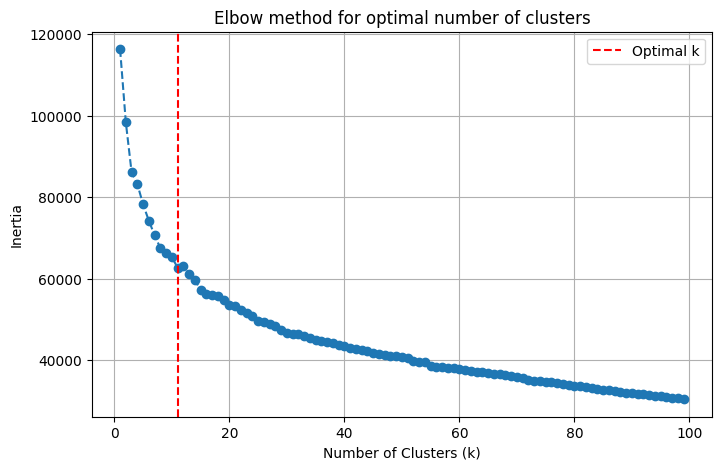

Optimal number of clusters: 11


In [ ]:
from kneed import KneeLocator

# inertia 
k_values = range(1, 100)
inertia_values = []
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=0, n_init="auto")
    kmeans.fit(valid_embeddings)
    inertia_values.append(kmeans.inertia_)
    

knee_locator = KneeLocator(k_values, inertia_values, curve="convex", direction="decreasing")
optimal_k = knee_locator.knee

plt.figure(figsize=(8, 5))
plt.plot(k_values, inertia_values, marker='o', linestyle='--')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.axvline(optimal_k, color='red', linestyle='--', label='Optimal k')
plt.legend()
plt.title('Elbow method for optimal number of clusters')
plt.grid(True)
plt.show()
print(f"Optimal number of clusters: {optimal_k}")


# Use the optimal number of clusters and for each cluster, calculate the centroid. Then get "m" many sample points per each cluster.

In [ ]:
import numpy as np
from sklearn.cluster import KMeans

# Assuming n_clusters and optimal_k are already defined
n_clusters = optimal_k  # number of clusters
kmeans = KMeans(n_clusters=n_clusters, random_state=0, n_init="auto")
cluster_labels = kmeans.fit_predict(valid_embeddings)
clusters = kmeans.labels_

cluster_dict = []
for idx, cluster in enumerate(cluster_labels):
    cluster_dict.append({"cluster": cluster, "embedding": valid_embeddings[idx], "file_path": image_paths[idx]})

centroids = kmeans.cluster_centers_

# Number of images per cluster
cluster_sizes = np.bincount(cluster_labels)
# Calculate the maximum number of images the user can input
max_images = np.sum(cluster_sizes)

print(f"Number of clusters: {n_clusters}")
print(f"Cluster sizes: {cluster_sizes}")
print(f"\nMaximum number of images available: {max_images}")

# User input for the number of images to sample
while True:
    user_input = int(input(f"Enter the number of images you want to sample (1-{max_images}): "))
    if 1 <= user_input <= max_images:
        break
    else:
        print(f"Please enter a number between 1 and {max_images}.")

# Rest of the code remains the same

# User input for the number of images to sample
user_input = int(input("Enter the number of images you want to sample: "))

# Calculate the ideal number of images per cluster
ideal_per_cluster = user_input / n_clusters

# Calculate sampling weights for each cluster
weights = cluster_sizes / np.sum(cluster_sizes)

# Initialize dictionary to store sampled indices
sampled_indices = {}

for cluster_id, centroid in enumerate(centroids):
    # Calculate the number of samples for this cluster
    cluster_sample_size = int(np.round(weights[cluster_id] * user_input))
    
    # Ensure at least one sample per cluster
    cluster_sample_size = max(1, cluster_sample_size)
    
    # Adjust if we're overshooting the total
    if sum(len(indices) for indices in sampled_indices.values()) + cluster_sample_size > user_input:
        cluster_sample_size = user_input - sum(len(indices) for indices in sampled_indices.values())
    
    # Calculate distances and get indices of closest points
    distances = np.linalg.norm(valid_embeddings - centroid, axis=1)
    cluster_mask = cluster_labels == cluster_id
    cluster_distances = distances[cluster_mask]
    cluster_indices = np.where(cluster_mask)[0]
    closest_indices = cluster_indices[np.argsort(cluster_distances)[:cluster_sample_size]]
    
    sampled_indices[cluster_id] = closest_indices

# Print sampling results
total_sampled = sum(len(indices) for indices in sampled_indices.values())
print(f"\nTotal images sampled: {total_sampled}")
for cluster_id, indices in sampled_indices.items():
    print(f"Cluster {cluster_id}: {len(indices)} images sampled")

# Create a list of sampled image paths
sampled_image_paths = []
for cluster_id, indices in sampled_indices.items():
    for idx in indices:
        sampled_image_paths.append(image_paths[idx])

print(f"\nNumber of sampled images: {len(sampled_image_paths)}")


Number of clusters: 11
Cluster sizes: [ 60  57  80  64  54  66 192  31 134  22 109]
Cluster 0 has 60 points, we will sample 6 points
Cluster 1 has 57 points, we will sample 5 points
Cluster 2 has 80 points, we will sample 8 points
Cluster 3 has 64 points, we will sample 6 points
Cluster 4 has 54 points, we will sample 5 points
Cluster 5 has 66 points, we will sample 6 points
Cluster 6 has 192 points, we will sample 19 points
Cluster 7 has 31 points, we will sample 3 points
Cluster 8 has 134 points, we will sample 13 points
Cluster 9 has 22 points, we will sample 2 points
Cluster 10 has 109 points, we will sample 10 points


In [ ]:
# Find the closest images to each centroid
representatives = []  # List to store representative images for each cluster

# Iterate over each cluster and find the closest points
for cluster_id, centroid in enumerate(centroids):
    # Compute distances from all valid embeddings to the centroid
    distances = np.linalg.norm(np.array(valid_embeddings) - centroid, axis=1)
    
    # Get indices of the closest images (m closest points)
    m = int(cluster_sizes[cluster_id] * weighted_percentage)
    closest_indices = np.argsort(distances)[:m]
    
    # Create a dictionary for this cluster with image paths and embeddings
    cluster_representative = {
        "cluster": cluster_id,
        # "centroid": centroid.tolist(),  # Convert centroid to list for better readability
        "closest_images": [
            {
                "file_path": image_paths[idx],
                # "embedding": valid_embeddings[idx].tolist()  # Convert embedding to list
            }
            for idx in closest_indices
        ]
    }
    
    representatives.append(cluster_representative)



In [ ]:

selected_representatives_images = [] # get the actual image paths
for rep in representatives:
    for path in rep["closest_images"]:
        selected_representatives_images.append(path['file_path'])

print(f"Number of selected representative images: {len(selected_representatives_images)}")

# Convert list to a dictionary with keys and values being the same
my_dict = {item: item for item in selected_representatives_images}

# Write the dictionary to a JSON file
with open('../output/selected_representatives_image.json', 'w') as json_file:
    json.dump(my_dict, json_file)

# Convert the selected representative images to COCO format
convert_selected_images_to_coco(selected_representatives_images, '../output/selected_representatives_coco.json')

Number of selected representative images: 83
[{'id': '../output/video_frames/417/VID003A/2437.jpg', 'width': 1920, 'height': 1080, 'file_name': '../output/video_frames/417/VID003A/2437.jpg', 'metadata': 1008}, {'id': '../output/video_frames/417/VID003A/2496.jpg', 'width': 1920, 'height': 1080, 'file_name': '../output/video_frames/417/VID003A/2496.jpg', 'metadata': 1008}, {'id': '../output/video_frames/417/VID003A/2457.jpg', 'width': 1920, 'height': 1080, 'file_name': '../output/video_frames/417/VID003A/2457.jpg', 'metadata': 1024}, {'id': '../output/video_frames/417/VID003A/2453.jpg', 'width': 1920, 'height': 1080, 'file_name': '../output/video_frames/417/VID003A/2453.jpg', 'metadata': 3}, {'id': '../output/video_frames/417/VID003A/2280.jpg', 'width': 1920, 'height': 1080, 'file_name': '../output/video_frames/417/VID003A/2280.jpg', 'metadata': 1008}, {'id': '../output/video_frames/417/VID003A/2435.jpg', 'width': 1920, 'height': 1080, 'file_name': '../output/video_frames/417/VID003A/243

# Export Image and Ground Truth File

In [ ]:
selected_representatives_ground_truth = []
for image_path in selected_representatives_images:
    image_path = image_path.replace("output/video_frames", "data/ground_truth")
    # add /preds before the json
    path_parts = image_path.split('/')

    if len(path_parts) > 2:
        path_parts.insert(-1, 'preds')  # Insert 'preds' two positions before the end
    
    # Reconstruct the path with 'preds' included
    image_path_with_preds = '/'.join(path_parts)
    image_path = image_path_with_preds

    image_path = image_path.replace(".jpg", ".json")
    selected_representatives_ground_truth.append(image_path)

print(selected_representatives_ground_truth[:5])
print(selected_representatives_images[:5])

# export selected to /output/exported_data
import shutil

# Create the directory if it does not exist
output_dir = '../output/exported_data/'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Copy the selected representative images to the output directory
for image in selected_representatives_images:
    image_path = image.split('/') # split the path to get the last part
    # join the path back excluding the last part
    image_path = (image_path[3:-1])
    image_path = '../output/dataset_export/'+ '/'.join(image_path) + "/preds"
    print(image_path)
    if not os.path.exists(image_path):
        os.makedirs(image_path)
        print(f"Created directory: {image_path}")
    
    shutil.copy(image, image_path)

# Copy the selected representative ground truth files to the output directory
for gt in selected_representatives_ground_truth:
    gt_path = gt.split('/') # split the path to get the last part
    # join the path back excluding the last part
    gt_path = (gt_path[3:-1])
    gt_path = '../output/dataset_export/'+ '/'.join(gt_path)
    print(gt_path)
    if not os.path.exists(gt_path):
        os.makedirs(gt_path)
        print(f"Created directory: {gt_path}")
    
    shutil.copy(gt, gt_path)

['../data/ground_truth/417/VID003A/preds/2437.json', '../data/ground_truth/417/VID003A/preds/2496.json', '../data/ground_truth/417/VID003A/preds/2457.json', '../data/ground_truth/417/VID003A/preds/2453.json', '../data/ground_truth/417/VID003A/preds/2280.json']
['../output/video_frames/417/VID003A/2437.jpg', '../output/video_frames/417/VID003A/2496.jpg', '../output/video_frames/417/VID003A/2457.jpg', '../output/video_frames/417/VID003A/2453.jpg', '../output/video_frames/417/VID003A/2280.jpg']
../output/dataset_export/417/VID003A/preds
../output/dataset_export/417/VID003A/preds
../output/dataset_export/417/VID003A/preds
../output/dataset_export/417/VID003A/preds
../output/dataset_export/417/VID003A/preds
../output/dataset_export/417/VID003A/preds
../output/dataset_export/417/VID003A/preds
../output/dataset_export/417/VID003A/preds
../output/dataset_export/417/VID003A/preds
../output/dataset_export/417/VID003A/preds
../output/dataset_export/417/VID003A/preds
../output/dataset_export/432/V

# Export Filtered Coco File and Images from Dataset 

In [ ]:
import fiftyone as fo
import fiftyone.brain as fob


from coco_converter import categories # import coco categories for detection

# Define the directory where you want to export the dataset
export_dir = "../output/selected_representatives_dataset"

# dataset_rest = fo.Dataset.from_images(selected_frames_images)
dataset = fo.Dataset.from_dir(
    data_path="../output/selected_representatives_image.json",
    labels_path="../output/selected_representatives_coco.json",
    dataset_type=fo.types.COCODetectionDataset,
)


# Export the dataset to COCO format
dataset.export(
    export_dir=export_dir,
    dataset_type=fo.types.COCODetectionDataset,
    categories=categories
)

# Export the dataset to the specified directory
dataset.export(
    export_dir=export_dir,
    dataset_type=fo.types.ImageDirectory
)


 100% |███████████████████| 83/83 [3.2s elapsed, 0s remaining, 26.0 samples/s]      
Directory '../output/selected_representatives_dataset' already exists; export will be merged with existing files
Found multiple fields ['detections', 'segmentations'] with compatible type (<class 'fiftyone.core.labels.Detections'>, <class 'fiftyone.core.labels.Polylines'>, <class 'fiftyone.core.labels.Keypoints'>); exporting 'detections'
 100% |███████████████████| 83/83 [589.5ms elapsed, 0s remaining, 140.8 samples/s]      
Directory '../output/selected_representatives_dataset' already exists; export will be merged with existing files
 100% |███████████████████| 83/83 [572.9ms elapsed, 0s remaining, 144.9 samples/s]      


# View filtered dataset

In [ ]:
# View the dataset in Fiftyone and visualize the data + embeddings
fob.compute_visualization(
    dataset,
    embeddings="resnet101",
    method="umap",
    brain_key="umap_resnet101",
    patches_field="detections"
)

session = fo.launch_app(dataset)
session.wait()

Computing patch embeddings...
 100% |███████████████████| 83/83 [9.4s elapsed, 0s remaining, 9.9 samples/s]       
Generating visualization...


AttributeError: module 'umap' has no attribute 'UMAP'